In [1]:
import sys; sys.path.append(".")

%reload_ext autoreload
%autoreload 2

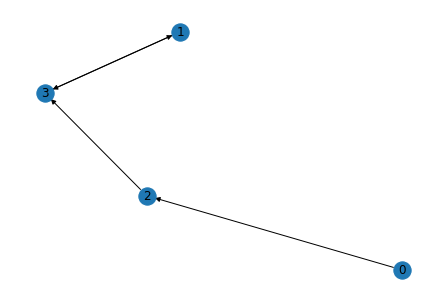

In [17]:
import networkx as nx

in_degrees = [0, 1, 1, 2]
out_degrees = [1, 1, 1, 1]
nkk = {1: {1: 2, 2: 2}}
G = nx.directed_joint_degree_graph(in_degrees, out_degrees, nkk)
nx.draw(G, with_labels=True)

In [29]:
import networkx as nx

def twitter():
    G = nx.DiGraph()
    with open("twitter.txt", "r") as lines:
        for line in lines:
            a, b = line.split()
            G.add_edge(a, b)
    return G

twitter()